In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

In [2]:
!pip install mlflow

In [3]:
image_dir = Path('20-50')

filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
def extract_age(filepath):
    parent_directory = os.path.dirname(filepath)
    return os.path.split(parent_directory)[1]

ages = pd.Series(filepaths.map(extract_age), name='Age').astype(int)

images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True) #suffle data
images = images[:1000]
print(images.Age)


0      43
1      28
2      39
3      44
4      34
       ..
995    35
996    40
997    34
998    26
999    35
Name: Age, Length: 1000, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(images, test_size = 0.1, random_state = 1)
train, valid = train_test_split(train, test_size = 0.2, random_state = 1)

In [5]:
class ImageAgeDataset() :
  def __init__(self , images) :
    self.age = images.Age.values
    self.paths = images.Filepath.values

  def __len__(self) :
    return len(self.age)

  def __getitem__(self , item) :
    out = dict()
    path = self.paths[item]
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image , dtype = float)
    out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255
    out['y'] = torch.tensor(self.age[item], dtype= torch.long) #CrossEntropyLoss()'s forward(probs, y) function requires torch.long for y
    return out

In [6]:
train_dataset = ImageAgeDataset(train)
valid_dataset = ImageAgeDataset(valid)

In [7]:
from torchvision import models
import torch
import mlflow
import mlflow.pytorch

resnet18_pretrained = models.resnet18(pretrained=True)

#hparams
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
BATCH_SIZE = 20
MAX_WAIT = 3
EPOCHS = 3
LR = 1

#---------------------
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True ,
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
)
#---------------------
model = resnet18_pretrained;
model.to(DEVICE)
#---------------------
loss_fn = nn.CrossEntropyLoss()
#---------------------
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
#---------------------
from tqdm.notebook import tqdm
import numpy as np
def train_step(model , optimizer , dataloader):
  model.train()
  total_loss = 0
  for data in tqdm(dataloader):
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    y_hat = model(x).to(DEVICE) #to apply model(x), x and model must be in the same place (device)
    loss = loss_fn(y_hat , y) #enough for y_hat and y to be in the same device
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
  #total_loss.backward()
  #optimizer.step()
  #optimizer.zero_grad()
  return total_loss/len(dataloader)

def valid_step(model, dataloader):
  model.eval()
  total_loss = 0
  for data in tqdm(dataloader):
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    with torch.no_grad():
      y_hat = model(x).to(DEVICE)
      loss = loss_fn(y_hat , y)
    total_loss += loss.item()
  return total_loss/len(dataloader)


def main(model, optimizer, train_dataloader, valid_dataloader):
    mlflow.start_run(run_name="custom name")
    mlflow.log_param("use_cuda", USE_CUDA)
    mlflow.log_param("device", str(DEVICE))
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("max_wait", MAX_WAIT)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("learning_rate", LR)

    model = resnet18_pretrained
    model.to(DEVICE)
    mlflow.pytorch.log_model(model, "model")

    train_losses = []
    valid_losses = []
    min_valid_loss = np.inf
    patience = 0

    for epoch in range(EPOCHS):
        train_loss = train_step(model, optimizer, train_dataloader)
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        train_losses.append(train_loss)

        valid_loss = valid_step(model, valid_dataloader)
        mlflow.log_metric("valid_loss", valid_loss, step=epoch)
        valid_losses.append(valid_loss)
        print(f'EPOCH = {epoch}')
        print(f'train_loss = {train_loss}')
        print(f'valid_loss = {valid_loss}')

        if valid_loss > min_valid_loss:
            patience += 1
        else:
            min_valid_loss = valid_loss
            patience = 0

        if patience > MAX_WAIT:
            print(f'EARLY STOPPING AT EPOCH = {epoch}')
            break
    torch.save(model.state_dict(), "model.pth")
    mlflow.log_artifact("model.pth")

    mlflow.end_run()
    # Plotting the train loss and valid loss using seaborn
    epochs = range(len(train_losses))
    sns.set_style("darkgrid")
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss and Valid Loss')
    plt.legend()
    plt.ylim(0, 20)  # Set y-axis range from 0 to 20
    plt.show()
    return train_losses, valid_losses

/Users/jeesuppark/opt/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jeesuppark/opt/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/Users/jeesuppark/opt/miniconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

EPOCH = 0
train_loss = 52.31324188576804
valid_loss = 1135.1847635904949


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

EPOCH = 1
train_loss = 3.7416034671995373
valid_loss = 4.030769427617391


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

EPOCH = 2
train_loss = 3.7298260397381253
valid_loss = 3.972356822755602


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

EPOCH = 3
train_loss = 3.7863686747021146
valid_loss = 3.8870942062801785


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

EPOCH = 4
train_loss = 3.671418607234955
valid_loss = 3.759595023261176


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

EPOCH = 5
train_loss = 3.661495440536075
valid_loss = 3.925106790330675


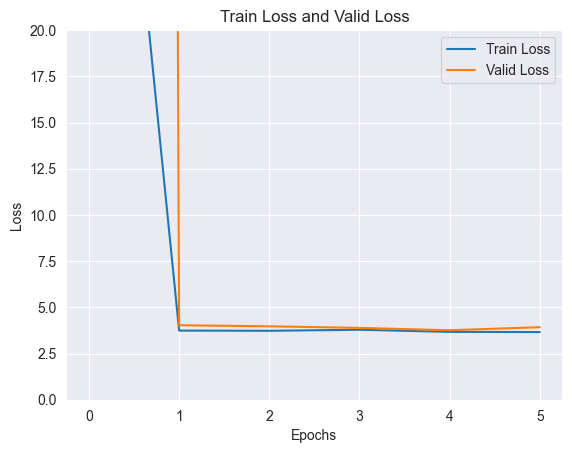

In [8]:
train_losses, valid_losses = main(
    model = model,
    optimizer = optimizer,
    train_dataloader = train_dataloader,
    valid_dataloader = valid_dataloader
)

In [11]:
test_dataset = ImageAgeDataset(test)

In [12]:
len(test_dataset)

100

Image 3 is 69 years old and is predicted 40 years old


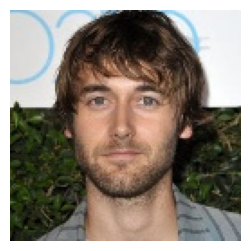

In [19]:
def visualize(image):
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(image)
    
import cv2
import torch

id = 3
softmax = nn.Softmax(dim=1)
image = test_dataset[id]['x'].to(DEVICE)  # Get the image tensor
image = image.unsqueeze(0)  # Add an extra dimension to match the model's input shape
y_hat_id = softmax(model(image))

def pred(x):
    for i in range(len(x[0])):
        if x[0][i] == torch.max(x[0]).item(): 
            return i

true_age = train_dataset[id]['y'].item() + 20
print(f"Image {id} is {true_age} years old and is predicted {pred(y_hat_id)+20} years old")

# Load and visualize the image
image_path = test.iloc[id].Filepath
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)
